In [1]:
import cPickle as pickle
import numpy as np
from sklearn import metrics
from sklearn import naive_bayes
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import coo_matrix, hstack
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import gensim

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential, load_model
from keras.layers.embeddings import Embedding
from keras.layers import Dense, Embedding, CuDNNGRU, LSTM, CuDNNLSTM, Flatten, Bidirectional, Dropout, Conv1D, MaxPool1D
from keras.initializers import Constant
from keras.optimizers import Adam, Adamax, SGD, RMSprop
from keras.utils import to_categorical
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

import tensorflow as tf

import warnings

%matplotlib inline
plt.style.use('ggplot')
warnings.filterwarnings('ignore')

Using TensorFlow backend.


# Data Loading

* Loading the preprocessed input data. Preprocessing was done before due to the difficulties of running the neccessary tools on this platform. It consisted of a tokeniser and a lemmantiser.
* Loading the sentiment lexicon


In [2]:
!git clone https://github.com/stadanapisem/Sentiment-Analysis_SerbMR.git
#!wget https://github.com/vukbatanovic/SerbMR/releases/download/v1.0/SerbMR-2C.csv
#!wget https://github.com/vukbatanovic/SerbMR/releases/download/v1.0/SerbMR-3C.csv

Cloning into 'Sentiment-Analysis_SerbMR'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 35 (delta 14), reused 17 (delta 5), pack-reused 0
Unpacking objects: 100% (35/35), done.


In [3]:
with open('Sentiment-Analysis_SerbMR/lemmatised_SerbMR-2C.p') as f:
  data2C = pickle.load(f)

with open('Sentiment-Analysis_SerbMR/tokenised_SerbMR-2C_with_periods.pickle') as f:
  tokenised2C = pickle.load(f)
  
print('Data two class: %d examples' % np.shape(data2C)[0])

Data two class: 1682 examples


In [4]:
with open('Sentiment-Analysis_SerbMR/lemmatised_SerbMR-3C.p') as f:
  data3C = pickle.load(f)
  
with open('Sentiment-Analysis_SerbMR/tokenised_SerbMR-3C_with_periods.pickle') as f:
  tokenised3C = pickle.load(f)
  
print('Data three class: %d examples' % np.shape(data3C)[0])

Data three class: 2523 examples


In [5]:
with open('Sentiment-Analysis_SerbMR/sr.lexicon') as f:
  lex = f.readlines()

lexicon = {}
for x in lex:
  x = x.split()
  lexicon[x[0].decode('utf8')] = int(x[1].strip())

print('Sentimen lexicon contains %d words' % len(lexicon))

Sentimen lexicon contains 2114 words


#### Utilities

In [0]:
# from https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823
def print_confusion_matrix(confusion_matrix, class_names, normalize=True, figsize = (5,4), fontsize=14):
  """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.

  Arguments
  ---------
  confusion_matrix: numpy.ndarray
      The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
      Similarly constructed ndarrays can also be used.
  class_names: list
      An ordered list of class names, in the order they index the given confusion matrix.
  figsize: tuple
      A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
      the second determining the vertical size. Defaults to (10,7).
  fontsize: int
      Font size for axes labels. Defaults to 14.

  Returns
  -------
  matplotlib.figure.Figure
      The resulting confusion matrix figure
  """
  if normalize:
        confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
       
  df_cm = pd.DataFrame(
      confusion_matrix, index=class_names, columns=class_names, 
  )
  fig = plt.figure(figsize=figsize)
  fmt = '.2f' if normalize else 'd'
  try:
      heatmap = sns.heatmap(df_cm, annot=True, fmt=fmt)
  except ValueError:
      raise ValueError("Confusion matrix values must be integers.")
  heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
  heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  fig.tight_layout()
  plt.show()

## Train / Validation / Test split


In [0]:
def fix_double_split_data(data):
  return [x[0] for x in data[0]], [x[0] for x in data[1]], data[2], data[3]

def do_double_split(data, toks, split):
  examples = []
  labels = []
  
  for i, row in enumerate(data):
      examples.append((u' '.join(row[0]), u' '.join(toks[i][0])))
      labels.append(row[1])

  return train_test_split(examples, labels, train_size=split, shuffle=True, stratify=labels)

def do_tri_split(data, tokens):
  X_train, X_test, y_train, y_test = do_double_split(data, tokens, 0.7)
  X_validation, X_test, y_validation, y_test = train_test_split(X_test, y_test, train_size=0.5, shuffle=True, stratify=y_test)

  return {
      'Xtrain' : X_train,
      'ytrain' : y_train,
      'Xval' : X_validation,
      'yval' : y_validation,
      'Xtst' : X_test,
      'ytst' : y_test
  }

In [8]:
data_2_class = do_tri_split(data2C, tokenised2C)

counts = dict(zip(*np.unique(data_2_class['ytrain'], return_counts=True)))
print('Two classes split')
print('Training using %d examples\n\tPositive - %d\n\tNegative - %d' % (len(data_2_class['Xtrain']), counts[-1], counts[1]))

counts = dict(zip(*np.unique(data_2_class['yval'], return_counts=True)))
print('Validating using %d examples\n\tPositive - %d\n\tNegative - %d' % (len(data_2_class['Xval']), counts[-1], counts[1]))

counts = dict(zip(*np.unique(data_2_class['ytst'], return_counts=True)))
print('Testing using %d examples\n\tPositive - %d\n\tNegative - %d' % (len(data_2_class['Xtst']), counts[-1], counts[1]))

Two classes split
Training using 1177 examples
	Positive - 588
	Negative - 589
Validating using 252 examples
	Positive - 126
	Negative - 126
Testing using 253 examples
	Positive - 127
	Negative - 126


In [9]:
data_3_class = do_tri_split(data3C, tokenised3C)

counts = dict(zip(*np.unique(data_3_class['ytrain'], return_counts=True)))
print('Three classes split')
print('Training using %d examples\n\tPositive - %d\n\tNeutral - %d\n\tNegative - %d' % (len(data_3_class['Xtrain']), counts[-1], counts[0], counts[1]))

counts = dict(zip(*np.unique(data_3_class['yval'], return_counts=True)))
print('Validating using %d examples\n\tPositive - %d\n\tNeutral - %d\n\tNegative - %d' % (len(data_3_class['Xval']), counts[-1], counts[0], counts[1]))

counts = dict(zip(*np.unique(data_3_class['ytst'], return_counts=True)))
print('Testing using %d examples\n\tPositive - %d\n\tNeutral - %d\n\tNegative - %d' % (len(data_3_class['Xtst']), counts[-1], counts[0], counts[1]))

Three classes split
Training using 1766 examples
	Positive - 588
	Neutral - 589
	Negative - 589
Validating using 378 examples
	Positive - 126
	Neutral - 126
	Negative - 126
Testing using 379 examples
	Positive - 127
	Neutral - 126
	Negative - 126


# Experiment 001
Solution based only on the sentiment lexicon. The model is comprised of one parameter only - limit. The average polarity of each sample is calculated (essentially wheather there are more positive or negative words). The prediction only takes into consideration if the calculated average is grater than the limit or not.

For the three class data, the model is comprised of two parameters, the positive and the negative limit. The parameters determine wheather the example is positive (if the mean word polarity is grater than positive limit), negative (if the mean word polarity is less than negative limit) or neutral (if the mean word polarity is between those limits).

#### 2 Class

('Training accuracy:', 0.6304832713754647)
('Model limit:', 0.025000000000000466)
Evaluation
('Accuracy', 0.629080118694362)
('F1 Score', 0.5318352059925093)


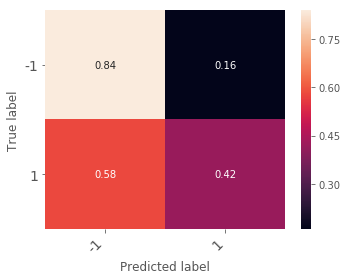

In [10]:
def run(data, LIMIT):
  results = []
  for row in data:
    words = row.split(' ')
    polarity = []
    for w in words:
      polarity.append(lexicon.get(w, 0))

    if np.mean(polarity) > LIMIT:
      results.append(1)
    else: results.append(-1)

  return results

data = fix_double_split_data(do_double_split(data2C, tokenised2C, 0.8))

max_acc = -1
res = -1

for LIMIT in np.arange(-0.5, 0.2, 0.005):
  results = run(data[0], LIMIT)
  acc = metrics.accuracy_score(data[2], results)

  if acc > max_acc:
    max_acc = acc
    res = LIMIT

print('Training accuracy:', max_acc)
print('Model limit:', res)

results = run(data[1], res)

print ('Evaluation')
print('Accuracy', metrics.accuracy_score(data[3], results))
print('F1 Score', metrics.f1_score(data[3], results))
  
print_confusion_matrix(metrics.confusion_matrix(data[3], results), ["-1", "1"])

#### 3 Class

('Training accuracy:', 0.44350842418235875)
('Model neg and pos limit:', 0.010000000000000286, 0.025000000000000105)
Evaluation
('Accuracy', 0.40594059405940597)


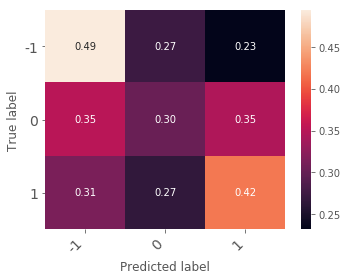

In [11]:
def run(data, posLIMIT, negLIMIT):
  results = []
  for row in data:
    words = row.split(' ')
    polarity = []
    for w in words:
      polarity.append(lexicon.get(w, 0))

    mean_pol = np.mean(polarity)
    if mean_pol >= posLIMIT:
      results.append(1)
    elif mean_pol <= negLIMIT: 
      results.append(-1)
    else:
      results.append(0)

  return results

data = fix_double_split_data(do_double_split(data3C, tokenised3C, 0.8))

max_acc = 0
res_min = -1
res_max = -1

for posLIMIT in np.arange(-0.1, 0.2, 0.005):
  for negLIMIT in np.arange(-0.3, 0.05, 0.005):
    if negLIMIT >= posLIMIT:
      continue
    results = run(data[0], posLIMIT, negLIMIT)

    acc = metrics.accuracy_score(data[2], results)
    
    if acc > max_acc:
      max_acc = acc
      res_min = negLIMIT
      res_max = posLIMIT
    
print('Training accuracy:', max_acc)
print('Model neg and pos limit:', res_min, res_max)
    
results = run(data[1], res_max, res_min)
    
print('Evaluation')
print('Accuracy', metrics.accuracy_score(data[3], results))
# print(metrics.confusion_matrix(data[3], results))
print_confusion_matrix(metrics.confusion_matrix(data[3], results), ["-1", "0", "1"])

# Experiment 002

Solution based only on the sentiment lexicon, however this time it takes into consideration the ratio of positive / negative and the total number of words in the example.

#### 2 Class

('Accuracy', 0.5)


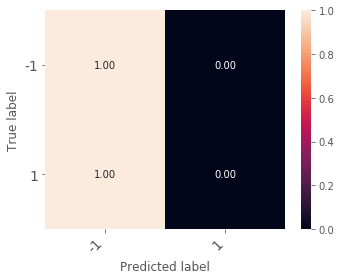

In [12]:
results = []
for row in data2C:
  words = row[0]
  polarity = []
  for w in words:
    polarity.append(lexicon.get(w, 0))
  
  counts = dict(zip(*np.unique(polarity, return_counts=True)))
#   print(counts)
  total_words = counts.get(-1, 0) + counts.get(0, 0) + counts.get(1, 0)
  ratio_pos = counts.get(1, 0) / total_words
  ratio_neg = counts.get(-1, 0) / total_words
  
  if ratio_pos > ratio_neg:
    results.append(1)
  else: results.append(-1)
    
print('Accuracy', metrics.accuracy_score([x[1] for x in data2C], results))
# print(metrics.confusion_matrix([x[1] for x in data2C], results))
print_confusion_matrix(metrics.confusion_matrix([x[1] for x in data2C], results), ["-1", "1"])

#### 3 Class

('Accuracy', 0.3333333333333333)


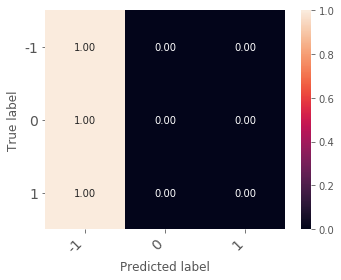

In [13]:
results = []
for row in data3C:
  words = row[0]
  polarity = []
  for w in words:
    polarity.append(lexicon.get(w, 0))
  
  counts = dict(zip(*np.unique(polarity, return_counts=True)))
#   print(counts)
  total_words = counts.get(-1, 0) + counts.get(0, 0) + counts.get(1, 0)
  ratio_pos = counts.get(1, 0) / total_words
  ratio_neg = counts.get(-1, 0) / total_words
  
  if ratio_pos > ratio_neg:
    results.append(1)
  else: results.append(-1)
    
print('Accuracy', metrics.accuracy_score([x[1] for x in data3C], results))
# print(metrics.confusion_matrix([x[1] for x in data3C], results))
print_confusion_matrix(metrics.confusion_matrix([x[1] for x in data3C], results), ["-1", "0", "1"])

# Experiment 003
Baseline model using multinomial naive Bayes with features only devised from the sentiment lexicon

#### Feature Extraction


In [0]:
def polarity_counts(data, posLIMIT, negLIMIT, skip = 1):
  words = data.split(' ')
  polarity = []
  for word in map(None, *(iter(words),) * skip):
    pol = []

    if skip == 1:
      word = [word]
      
    for w in word:
      if w:
        pol.append(lexicon.get(w, 0))
      else:
        break
    
   # if skip != 1:
    if np.mean(pol) >= posLIMIT:
      polarity.append(1)
    elif np.mean(pol) <= negLIMIT:
      polarity.append(-1)
    else:
      polarity.append(0)
    #else:
    #  polarity.append(pol)
  
  counts = dict(zip(*np.unique(polarity, return_counts=True)))
#   print(counts)
  return [counts.get(-1, 0), counts.get(0, 0), counts.get(1, 0)]

def sentence_polarity(data, posLIMIT, negLIMIT):
  polarity = []
  pol = []
  num_periods = 0
  words = data[1].split(' ')
  words_lem = data[0].split(' ')
  
  for i, word in enumerate(words):
    if ('.' in word and len(word) > 1) or "|" == word:
      num_periods += 1
      continue
#     print(word)
    if word == '.':
      num_periods += 1
#       print(pol)
      if np.mean(pol) >= posLIMIT:
        polarity.append(1)
      elif np.mean(pol) <= negLIMIT:
        polarity.append(-1)
      else:
        polarity.append(0)
      pol = []
    else:
#       print(i, word, words_lem[i - num_periods])
      pol.append(lexicon.get(words_lem[i - num_periods], 0))
      
  counts = dict(zip(*np.unique(polarity, return_counts=True)))
#   print(counts)
  return [counts.get(-1, 0), counts.get(0, 0), counts.get(1, 0)]
      

def create_feature_vector(data, posLIMIT, negLIMIT):
  features = []
  for i, example in enumerate(data):
    features += [polarity_counts(example[0], posLIMIT, negLIMIT) + polarity_counts(example[0], posLIMIT, negLIMIT, skip=2) 
                + polarity_counts(example[0], posLIMIT, negLIMIT, skip=3) + sentence_polarity(example, posLIMIT, negLIMIT)]
    
  return np.array(features)
  

#### 2 Class

('Max validation accuracy', 0.6587301587301587)
('Model limit', 0.075)
Evaluation
('Accuracy', 0.6007905138339921)


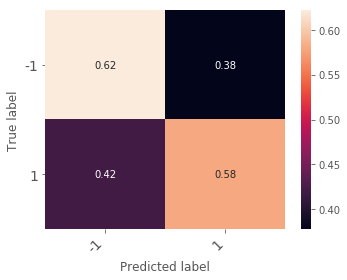

In [15]:
data = data_2_class.copy()

model = naive_bayes.MultinomialNB()

max_acc = 0
res = -1

for LIMIT in [0, 0.015, 0.03, 0.05, 0.075]:
  X_train = create_feature_vector(data['Xtrain'], LIMIT, LIMIT)
  X_val = create_feature_vector(data['Xval'], LIMIT, LIMIT)
  
  model = model.fit(X=X_train, y=data['ytrain'])
  acc = metrics.accuracy_score(data['yval'], model.predict(X_val))
#   print(acc)
  if acc > max_acc:
    max_acc = acc
    res = LIMIT

print('Max validation accuracy', max_acc)
print('Model limit', res)

X_train = create_feature_vector(data['Xtrain'], res, res)
model = model.fit(X=X_train, y=data['ytrain'])

X_tst = create_feature_vector(data['Xtst'], res, res)
predictions = model.predict(X_tst)

print('Evaluation')
print('Accuracy', metrics.accuracy_score(data['ytst'], predictions))
# print(metrics.confusion_matrix(data['ytst'], predictions))
print_confusion_matrix(metrics.confusion_matrix(data['ytst'], predictions), ["-1", "1"])

#### 3 Class

('Max validation accuracy', 0.4708994708994709)
('Model positive limit', 0.025)
('Model negative limit', -0.1)
Evaluation
('Accuracy', 0.40897097625329815)
[[80 14 33]
 [44 21 61]
 [56 16 54]]


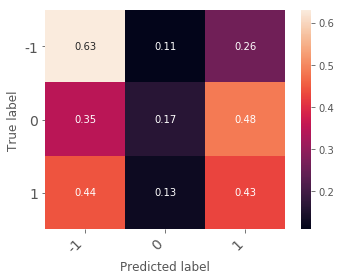

In [16]:
data = data_3_class.copy()

model = naive_bayes.MultinomialNB()

max_acc = 0
res = -1

for posLIMIT in [0, 0.015, 0.025, 0.05, 0.1]:
  for negLIMIT in [-0.2, -0.15, -0.1, -0.05, 0]:
    if negLIMIT >= posLIMIT:
      continue

    X_train = create_feature_vector(data['Xtrain'], posLIMIT, negLIMIT)
    X_val = create_feature_vector(data['Xval'], posLIMIT, negLIMIT)

    model = model.fit(X=X_train, y=data['ytrain'])
    acc = metrics.accuracy_score(data['yval'], model.predict(X_val))
    if acc > max_acc:
      max_acc = acc
      res = (posLIMIT, negLIMIT)

print('Max validation accuracy', max_acc)

if res[1] > res[0]:
  res = (res[0], res[1])
  
print('Model positive limit', res[0])
print('Model negative limit', res[1])

X_train = create_feature_vector(data['Xtrain'], res[0], res[1])
model = model.fit(X=X_train, y=data['ytrain'])

X_tst = create_feature_vector(data['Xtst'], res[0], res[1])
predictions = model.predict(X_tst)

print('Evaluation')
print('Accuracy', metrics.accuracy_score(data['ytst'], predictions))
print(metrics.confusion_matrix(data['ytst'], predictions))
print_confusion_matrix(metrics.confusion_matrix(data['ytst'], predictions), ["-1", "0", "1"])

# Experiment 004

Baseline model using multinomial naive Bayes with Bag-of-Words approach combined with the features of the sentiment lexicon

#### 2 Class

('Max validation acc', 0.8214285714285714)
('Train acc', 0.9983007646559049)
('Test acc', 0.782608695652174)


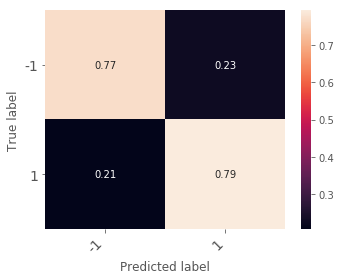

In [17]:
data = data_2_class.copy()
examples = data['Xtrain'] + data['Xtst'] + data['Xval']

vectoriser = CountVectorizer()
examples_tmp = vectoriser.fit_transform([x[0] for x in examples])

model = naive_bayes.MultinomialNB()
res = -1
max_acc = 0

for LIMIT in [0, 0.015, 0.03, 0.05]:
  examples_new = hstack([examples_tmp, coo_matrix(create_feature_vector(examples, LIMIT, LIMIT))]).toarray()

  X_train = examples_new[:len(data['ytrain'])]
  X_val = examples_new[len(data['ytrain']) + len(data['ytst']):]

# print(np.shape(X_train), np.shape(X_tst), np.shape(X_val))
# print(np.shape(data['Xtrain']), np.shape(data['Xtst']), np.shape(data['Xval']))
  model = model.fit(X=X_train, y=data['ytrain'])
  acc = metrics.accuracy_score(data['yval'], model.predict(X_val))
#   print(acc)
  if acc > max_acc:
    max_acc = acc
    res = LIMIT
  
print('Max validation acc', max_acc)
examples = hstack([examples_tmp, coo_matrix(create_feature_vector(examples, res, res))]).toarray()
X_train = examples[:len(data['ytrain'])]
model = model.fit(X=X_train, y=data['ytrain'])

X_tst = examples[len(data['ytrain']): len(data['ytrain']) + len(data['ytst'])]
y_pred = model.predict(X_tst)

print('Train acc', metrics.accuracy_score(data['ytrain'], model.predict(X_train)))
print('Test acc', metrics.accuracy_score(data['ytst'], y_pred))
print_confusion_matrix(metrics.confusion_matrix(data['ytst'], y_pred), ["-1", "1"])

#### 3 Class

('Max validation acc', 0.5714285714285714)
('Train acc', 0.9983012457531144)
('Test acc', 0.554089709762533)


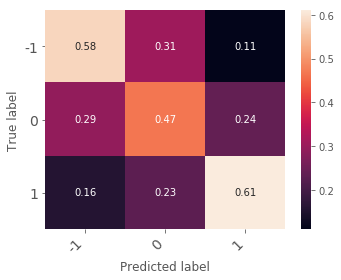

In [18]:
data = data_3_class.copy()
examples = data['Xtrain'] + data['Xtst'] + data['Xval']

vectoriser = CountVectorizer()
examples_tmp = vectoriser.fit_transform([x[0] for x in examples])

model = naive_bayes.MultinomialNB()
res = -1
max_acc = 0

for posLIMIT in [0, 0.015, 0.025, 0.05, 0.1]:
  for negLIMIT in [-0.2, -0.15, -0.1, -0.05]:
    if negLIMIT > posLIMIT:
      continue
  
  examples_new = hstack([examples_tmp, coo_matrix(create_feature_vector(examples, posLIMIT, negLIMIT))]).toarray()

  X_train = examples_new[:len(data['ytrain'])]
  X_val = examples_new[len(data['ytrain']) + len(data['ytst']):]

# print(np.shape(X_train), np.shape(X_tst), np.shape(X_val))
# print(np.shape(data['Xtrain']), np.shape(data['Xtst']), np.shape(data['Xval']))
  model = model.fit(X=X_train, y=data['ytrain'])
  acc = metrics.accuracy_score(data['yval'], model.predict(X_val))
#   print(acc)
  if acc > max_acc:
    max_acc = acc
    res = (posLIMIT, negLIMIT)
    
if res[1] > res[0]:
  res = (res[0], res[1])
  
print('Max validation acc', max_acc)
examples = hstack([examples_tmp, coo_matrix(create_feature_vector(examples, res[0], res[1]))]).toarray()
X_train = examples[:len(data['ytrain'])]
model = model.fit(X=X_train, y=data['ytrain'])

X_tst = examples[len(data['ytrain']): len(data['ytrain']) + len(data['ytst'])]
y_pred = model.predict(X_tst)

print('Train acc', metrics.accuracy_score(data['ytrain'], model.predict(X_train)))
print('Test acc', metrics.accuracy_score(data['ytst'], y_pred))
print_confusion_matrix(metrics.confusion_matrix(data['ytst'], y_pred), ["-1", "0", "1"])

# Experiment 005

#### Common

In [0]:
def get_model(classes, data_all, data_with_separation, EMBEDDING_DIM, window, min_count):
  data = list(data_all)

  examples = [x[0] for x in data]

  word2vec = gensim.models.Word2Vec(sentences=examples, size=EMBEDDING_DIM, window=window, min_count=min_count, workers=2, iter=5)
  words = list(word2vec.wv.vocab)
  print('Vocabulary size:', len(words))
  # print(model.wv.most_similar('dobar'))

  word2vec.wv.save_word2vec_format('word2vec_' + str(classes) + '_class.txt')
  
  wordvectors = {}
  with open('word2vec_' + str(classes) + '_class.txt') as f:
    vocab_size = int(f.readline().split()[0])

    for line in f:
      vals = line.split()
      wordvectors[vals[0]] = np.asarray(vals[1:], dtype=np.float)

  data = data_with_separation.copy()
  tokenizer = Tokenizer()

  tmp = data['Xtrain'] + data['Xtst'] + data['Xval']
  all_examples = [x[0] for x in tmp]
  
  tokenizer.fit_on_texts(all_examples)
  seq = tokenizer.texts_to_sequences(all_examples)

  longest_example = max([len(x.split()) for x in all_examples])
  vocab_size = len(tokenizer.word_index) + 1

  seq_padded = pad_sequences(seq, maxlen=longest_example)

  print('Longest review', longest_example)
  print('Unique tokens', len(tokenizer.word_index))
  print('padded', seq_padded.shape)

  X_train = pad_sequences(tokenizer.texts_to_sequences(all_examples[:len(data['ytrain'])]), maxlen=longest_example)
  X_tst = pad_sequences(tokenizer.texts_to_sequences(all_examples[len(data['ytrain']): len(data['ytrain']) + len(data['ytst'])]), maxlen=longest_example)
  X_val = pad_sequences(tokenizer.texts_to_sequences(all_examples[len(data['ytrain']) + len(data['ytst']):]), maxlen=longest_example)

  if classes == 3:
    ytrain = to_categorical(data['ytrain'], num_classes=classes)
    ytst = to_categorical(data['ytst'], num_classes=classes)
    yval = to_categorical(data['yval'], num_classes=classes)
  else:
    ytrain = to_categorical(list(map(lambda x: 0 if x == -1 else 1, data['ytrain'])))
    ytst = to_categorical(list(map(lambda x: 0 if x == -1 else 1, data['ytst'])))
    yval = to_categorical(list(map(lambda x: 0 if x == -1 else 1, data['yval'])))
    
  embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM + 1))

  for word, i in tokenizer.word_index.items():
    if i > vocab_size:
      continue
    embd = wordvectors.get(word)
    if embd is not None:
      embedding_matrix[i] = np.append(embd, lexicon.get(word, 0))

  print ('Embedding size', np.shape(embedding_matrix))
  
  model = Sequential()
  embedding_layer = Embedding(vocab_size, EMBEDDING_DIM + 1, embeddings_initializer=Constant(embedding_matrix), input_length=longest_example, trainable=True)
  model.add(embedding_layer)
  model.add(Bidirectional(CuDNNLSTM(256)))
  model.add(Dropout(0.3))
  model.add(Dense(classes, activation='softmax'))
  adamax = Adamax(lr=0.0001)
  model.compile(loss='categorical_crossentropy', optimizer=adamax, metrics=['acc'])
  print(model.summary())
  return model, [X_train, X_tst, X_val, ytrain, ytst, yval]

def plot_acc(train_data):
  plt.plot(train_data.history['acc'], label='train')
  plt.plot(train_data.history['val_acc'], label='validation')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.legend()
  plt.show()
  
def plot_loss(train_data):
  plt.plot(train_data.history['loss'], label='train')
  plt.plot(train_data.history['val_loss'], label='validation')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend()
  plt.show()

#### 2 Class

##### Hyperparameters



*   Embedding size = 200
*   Window = 3
*   Min count = 5



('Vocabulary size:', 11178)
('Longest review', 1831)
('Unique tokens', 47236)
('padded', (1682, 1831))
('Embedding size', (47237, 201))
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1831, 201)         9494637   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 512)               940032    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 1026      
Total params: 10,435,695
Trainable params: 10,435,695
Non-trainable params: 0
_____

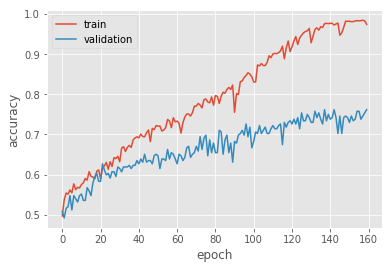

In [20]:
model, data = get_model(2, data2C, data_2_class, 200, 3, 5)
es = EarlyStopping(monitor='val_loss', mode='min', verbose='1', patience=50)
chpt = ModelCheckpoint('2_class_model_200_3_5.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
with tf.device('/gpu:0'):
  train_data = model.fit(data[0], data[3], validation_data=[data[2], data[5]], epochs=2000, batch_size=128, verbose=1, callbacks=[es, chpt])

plot_acc(train_data)

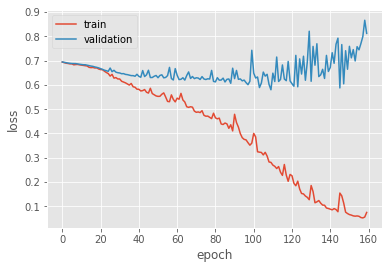

Test loss 0.7239, acc 0.7312
Train loss 0.0871, acc 0.9788


In [21]:
plot_loss(train_data)
model = load_model('2_class_model_200_3_5.h5')
print('Test loss %.4f, acc %.4f' % tuple(model.evaluate(data[1], data[4], verbose=0)))
print('Train loss %.4f, acc %.4f' % tuple(model.evaluate(data[0], data[3], verbose=0)))

##### Hyperparameters



*   Embedding size = 200
*   Window = 3
*   Min count = 10

('Vocabulary size:', 6299)
('Longest review', 1831)
('Unique tokens', 47236)
('padded', (1682, 1831))
('Embedding size', (47237, 201))
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1831, 201)         9494637   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 512)               940032    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 1026      
Total params: 10,435,695
Trainable params: 10,435,695
Non-trainable params: 0
_________________________________________________________________
None
Train on 1177 samples, validate on 252 samples
Epoch 1/2000
1177/1177 [==============================] - 15s 12ms/step - l

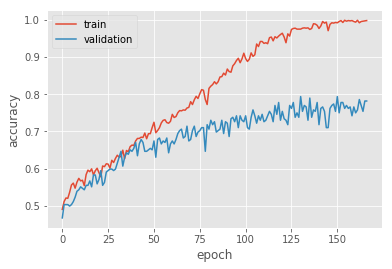

In [22]:
model, data = get_model(2, data2C, data_2_class, 200, 3, 10)
es = EarlyStopping(monitor='val_loss', mode='min', verbose='1', patience=50)
chpt = ModelCheckpoint('2_class_model_200_3_10.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
with tf.device('/gpu:0'):
  train_data = model.fit(data[0], data[3], validation_data=[data[2], data[5]], epochs=2000, batch_size=128, verbose=1, callbacks=[es, chpt])

plot_acc(train_data)

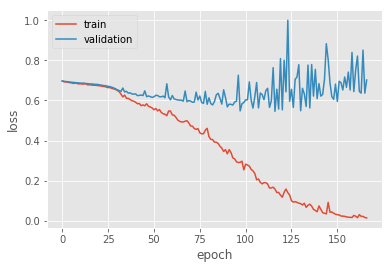

Test loss 0.7102, acc 0.7470
Train loss 0.0259, acc 0.9966


In [24]:
plot_loss(train_data)
model = load_model('2_class_model_200_3_10.h5')
print('Test loss %.4f, acc %.4f' % tuple(model.evaluate(data[1], data[4], verbose=0)))
print('Train loss %.4f, acc %.4f' % tuple(model.evaluate(data[0], data[3], verbose=0)))

##### Hyperparameters



*   Embedding size = 200
*   Window = 5
*   Min count = 5

('Vocabulary size:', 11178)
('Longest review', 1831)
('Unique tokens', 47236)
('padded', (1682, 1831))
('Embedding size', (47237, 201))
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 1831, 201)         9494637   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 512)               940032    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 1026      
Total params: 10,435,695
Trainable params: 10,435,695
Non-trainable params: 0
_________________________________________________________________
None
Train on 1177 samples, validate on 252 samples
Epoch 1/2000
1177/1177 [==============================] - 15s 13ms/step - 

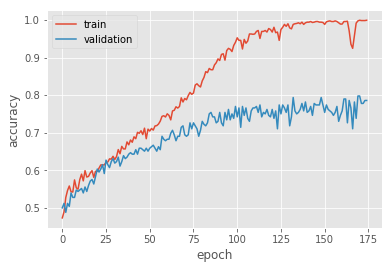

In [25]:
model, data = get_model(2, data2C, data_2_class, 200, 5, 5)
es = EarlyStopping(monitor='val_loss', mode='min', verbose='1', patience=50)
chpt = ModelCheckpoint('2_class_model_200_5_5.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
with tf.device('/gpu:0'):
  train_data = model.fit(data[0], data[3], validation_data=[data[2], data[5]], epochs=2000, batch_size=128, verbose=1, callbacks=[es, chpt])

plot_acc(train_data)

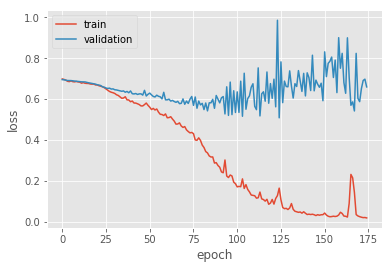

Test loss 0.6145, acc 0.7708
Train loss 0.0227, acc 0.9992


In [26]:
plot_loss(train_data)
model = load_model('2_class_model_200_5_5.h5')
print('Test loss %.4f, acc %.4f' % tuple(model.evaluate(data[1], data[4], verbose=0)))
print('Train loss %.4f, acc %.4f' % tuple(model.evaluate(data[0], data[3], verbose=0)))

##### Hyperparameters



*   Embedding size = 200
*   Window = 5
*   Min count = 10

('Vocabulary size:', 6299)
('Longest review', 1831)
('Unique tokens', 47236)
('padded', (1682, 1831))
('Embedding size', (47237, 201))
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 1831, 201)         9494637   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 512)               940032    
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 1026      
Total params: 10,435,695
Trainable params: 10,435,695
Non-trainable params: 0
_________________________________________________________________
None
Train on 1177 samples, validate on 252 samples
Epoch 1/2000
1177/1177 [==============================] - 15s 13ms/step - l

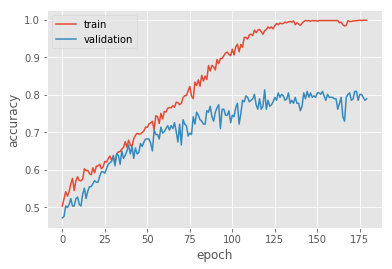

In [27]:
model, data = get_model(2, data2C, data_2_class, 200, 5, 10)
es = EarlyStopping(monitor='val_loss', mode='min', verbose='1', patience=50)
chpt = ModelCheckpoint('2_class_model_200_5_10.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
with tf.device('/gpu:0'):
  train_data = model.fit(data[0], data[3], validation_data=[data[2], data[5]], epochs=2000, batch_size=128, verbose=1, callbacks=[es, chpt])

plot_acc(train_data)

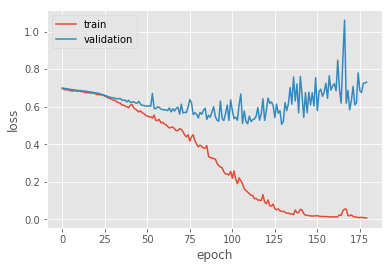

Test loss 0.6332, acc 0.7589
Train loss 0.0733, acc 0.9830


In [28]:
plot_loss(train_data)
model = load_model('2_class_model_200_5_10.h5')
print('Test loss %.4f, acc %.4f' % tuple(model.evaluate(data[1], data[4], verbose=0)))
print('Train loss %.4f, acc %.4f' % tuple(model.evaluate(data[0], data[3], verbose=0)))

##### Hyperparameters



*   Embedding size = 300
*   Window = 5
*   Min count = 10

('Vocabulary size:', 6299)
('Longest review', 1831)
('Unique tokens', 47236)
('padded', (1682, 1831))
('Embedding size', (47237, 301))
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 1831, 301)         14218337  
_________________________________________________________________
bidirectional_5 (Bidirection (None, 512)               1144832   
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 1026      
Total params: 15,364,195
Trainable params: 15,364,195
Non-trainable params: 0
_________________________________________________________________
None
Train on 1177 samples, validate on 252 samples
Epoch 1/2000
1177/1177 [==============================] - 16s 14ms/step - l

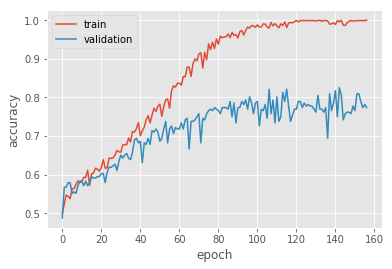

In [29]:
model, data = get_model(2, data2C, data_2_class, 300, 5, 10)
es = EarlyStopping(monitor='val_loss', mode='min', verbose='1', patience=50)
chpt = ModelCheckpoint('2_class_model_300_5_10.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
with tf.device('/gpu:0'):
  train_data = model.fit(data[0], data[3], validation_data=[data[2], data[5]], epochs=2000, batch_size=128, verbose=1, callbacks=[es, chpt])

plot_acc(train_data)

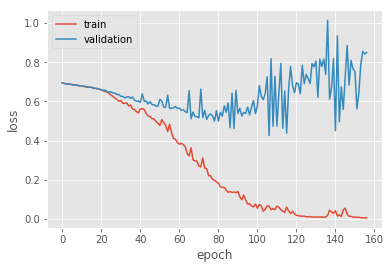

Test loss 0.6035, acc 0.8024
Train loss 0.0127, acc 0.9992


In [30]:
plot_loss(train_data)
model = load_model('2_class_model_300_5_10.h5')
print('Test loss %.4f, acc %.4f' % tuple(model.evaluate(data[1], data[4], verbose=0)))
print('Train loss %.4f, acc %.4f' % tuple(model.evaluate(data[0], data[3], verbose=0)))

##### Hyperparameters



*   Embedding size = 500
*   Window = 5
*   Min count = 10

('Vocabulary size:', 6299)
('Longest review', 1831)
('Unique tokens', 47236)
('padded', (1682, 1831))
('Embedding size', (47237, 501))
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 1831, 501)         23665737  
_________________________________________________________________
bidirectional_6 (Bidirection (None, 512)               1554432   
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 1026      
Total params: 25,221,195
Trainable params: 25,221,195
Non-trainable params: 0
_________________________________________________________________
None
Train on 1177 samples, validate on 252 samples
Epoch 1/2000
1177/1177 [==============================] - 20s 17ms/step - l

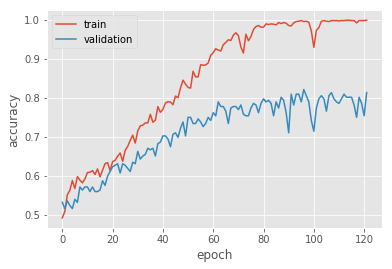

In [31]:
model, data = get_model(2, data2C, data_2_class, 500, 5, 10)
es = EarlyStopping(monitor='val_loss', mode='min', verbose='1', patience=50)
chpt = ModelCheckpoint('2_class_model_500_5_10.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
with tf.device('/gpu:0'):
  train_data = model.fit(data[0], data[3], validation_data=[data[2], data[5]], epochs=2000, batch_size=128, verbose=1, callbacks=[es, chpt])

plot_acc(train_data)

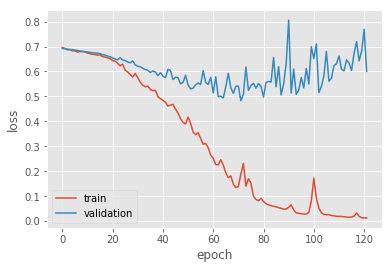

Test loss 0.6581, acc 0.7708
Train loss 0.0271, acc 0.9983


In [32]:
plot_loss(train_data)
model = load_model('2_class_model_500_5_10.h5')
print('Test loss %.4f, acc %.4f' % tuple(model.evaluate(data[1], data[4], verbose=0)))
print('Train loss %.4f, acc %.4f' % tuple(model.evaluate(data[0], data[3], verbose=0)))

##### Hyperparameters



*   Embedding size = 600
*   Window = 5
*   Min count = 10

('Vocabulary size:', 6299)
('Longest review', 1831)
('Unique tokens', 47236)
('padded', (1682, 1831))
('Embedding size', (47237, 601))
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1831, 601)         28389437  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 512)               1759232   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 1026      
Total params: 30,149,695
Trainable params: 30,149,695
Non-trainable params: 0
______

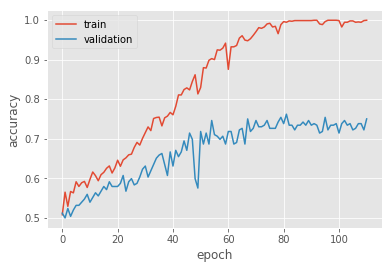

In [10]:
model, data = get_model(2, data2C, data_2_class, 600, 5, 10)
es = EarlyStopping(monitor='val_loss', mode='min', verbose='1', patience=50)
chpt = ModelCheckpoint('2_class_model_600_5_10.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
with tf.device('/gpu:0'):
  train_data = model.fit(data[0], data[3], validation_data=[data[2], data[5]], epochs=2000, batch_size=128, verbose=1, callbacks=[es, chpt])

plot_acc(train_data)

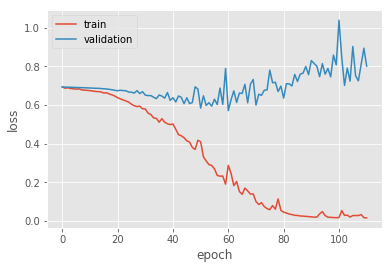

Test loss 0.6659, acc 0.7431
Train loss 0.0396, acc 0.9958


In [11]:
plot_loss(train_data)
model = load_model('2_class_model_600_5_10.h5')
print('Test loss %.4f, acc %.4f' % tuple(model.evaluate(data[1], data[4], verbose=0)))
print('Train loss %.4f, acc %.4f' % tuple(model.evaluate(data[0], data[3], verbose=0)))

#### 3 Class

##### Hyperparameters



*   Embedding size = 200
*   Window = 3
*   Min count = 5

('Vocabulary size:', 14438)
('Longest review', 1831)
('Unique tokens', 58435)
('padded', (2523, 1831))
('Embedding size', (58436, 201))
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1831, 201)         11745636  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 512)               940032    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 1539      
Total params: 12,687,207
Trainable params: 12,687,207
Non-trainable params: 0
_________________________________________________________________
None
Train on 1766 samples, validate on 378 samples
Epoch 1/2000
1766/1766 [==============================] - 21s 12ms/step - 

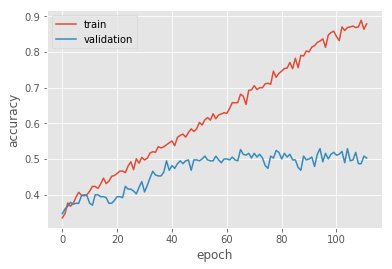

In [12]:
model, data = get_model(3, data3C, data_3_class, 200, 3, 5)
es = EarlyStopping(monitor='val_loss', mode='min', verbose='1', patience=50)
chpt = ModelCheckpoint('3_class_model_200_3_5.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
with tf.device('/gpu:0'):
  train_data = model.fit(data[0], data[3], validation_data=[data[2], data[5]], epochs=2000, batch_size=128, verbose=1, callbacks=[es, chpt])

plot_acc(train_data)

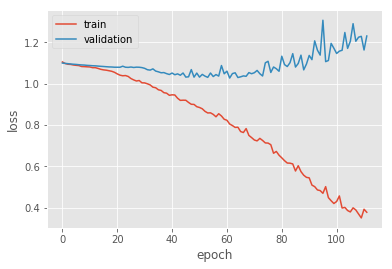

Test loss 1.1755, acc 0.5224
Train loss 0.3862, acc 0.8794


In [13]:
plot_loss(train_data)
model = load_model('3_class_model_200_3_5.h5')
print('Test loss %.4f, acc %.4f' % tuple(model.evaluate(data[1], data[4], verbose=0)))
print('Train loss %.4f, acc %.4f' % tuple(model.evaluate(data[0], data[3], verbose=0)))

##### Hyperparameters



*   Embedding size = 200
*   Window = 3
*   Min count = 10

('Vocabulary size:', 8450)
('Longest review', 1831)
('Unique tokens', 58435)
('padded', (2523, 1831))
('Embedding size', (58436, 201))
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 1831, 201)         11745636  
_________________________________________________________________
bidirectional_3 (Bidirection (None, 512)               940032    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 1539      
Total params: 12,687,207
Trainable params: 12,687,207
Non-trainable params: 0
_________________________________________________________________
None
Train on 1766 samples, validate on 378 samples
Epoch 1/2000
1766/1766 [==============================] - 21s 12ms/step - l

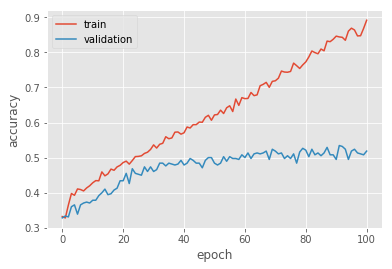

In [14]:
model, data = get_model(3, data3C, data_3_class, 200, 3, 10)
es = EarlyStopping(monitor='val_loss', mode='min', verbose='1', patience=50)
chpt = ModelCheckpoint('3_class_model_200_3_10.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
with tf.device('/gpu:0'):
  train_data = model.fit(data[0], data[3], validation_data=[data[2], data[5]], epochs=2000, batch_size=128, verbose=1, callbacks=[es, chpt])

plot_acc(train_data)

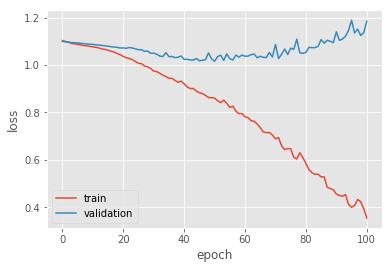

Test loss 1.1163, acc 0.5251
Train loss 0.4247, acc 0.8624


In [15]:
plot_loss(train_data)
model = load_model('3_class_model_200_3_10.h5')
print('Test loss %.4f, acc %.4f' % tuple(model.evaluate(data[1], data[4], verbose=0)))
print('Train loss %.4f, acc %.4f' % tuple(model.evaluate(data[0], data[3], verbose=0)))

##### Hyperparameters



*   Embedding size = 200
*   Window = 5
*   Min count = 5

('Vocabulary size:', 14438)
('Longest review', 1831)
('Unique tokens', 58435)
('padded', (2523, 1831))
('Embedding size', (58436, 201))
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 1831, 201)         11745636  
_________________________________________________________________
bidirectional_4 (Bidirection (None, 512)               940032    
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 1539      
Total params: 12,687,207
Trainable params: 12,687,207
Non-trainable params: 0
_________________________________________________________________
None
Train on 1766 samples, validate on 378 samples
Epoch 1/2000
1766/1766 [==============================] - 22s 12ms/step - 

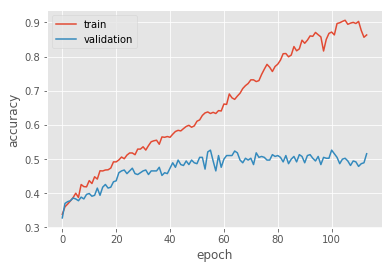

In [16]:
model, data = get_model(3, data3C, data_3_class, 200, 5, 5)
es = EarlyStopping(monitor='val_loss', mode='min', verbose='1', patience=50)
chpt = ModelCheckpoint('3_class_model_200_5_5.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
with tf.device('/gpu:0'):
  train_data = model.fit(data[0], data[3], validation_data=[data[2], data[5]], epochs=2000, batch_size=128, verbose=1, callbacks=[es, chpt])

plot_acc(train_data)

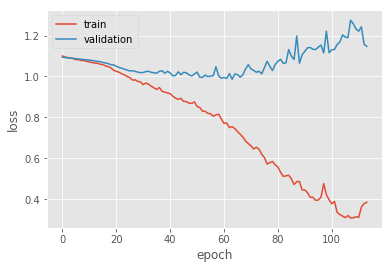

Test loss 1.0524, acc 0.4828
Train loss 0.8294, acc 0.6229


In [17]:
plot_loss(train_data)
model = load_model('3_class_model_200_5_5.h5')
print('Test loss %.4f, acc %.4f' % tuple(model.evaluate(data[1], data[4], verbose=0)))
print('Train loss %.4f, acc %.4f' % tuple(model.evaluate(data[0], data[3], verbose=0)))

##### Hyperparameters



*   Embedding size = 200
*   Window = 5
*   Min count = 10

('Vocabulary size:', 8450)
('Longest review', 1831)
('Unique tokens', 58435)
('padded', (2523, 1831))
('Embedding size', (58436, 201))
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 1831, 201)         11745636  
_________________________________________________________________
bidirectional_6 (Bidirection (None, 512)               940032    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 1539      
Total params: 12,687,207
Trainable params: 12,687,207
Non-trainable params: 0
_________________________________________________________________
None
Train on 1766 samples, validate on 378 samples
Epoch 1/2000
1766/1766 [==============================] - 22s 12ms/step - l

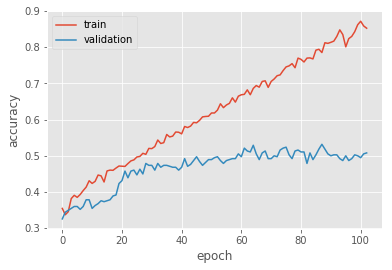

In [21]:
model, data = get_model(3, data3C, data_3_class, 200, 5, 10)
es = EarlyStopping(monitor='val_loss', mode='min', verbose='1', patience=50)
chpt = ModelCheckpoint('3_class_model_200_5_10.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
with tf.device('/gpu:0'):
  train_data = model.fit(data[0], data[3], validation_data=[data[2], data[5]], epochs=2000, batch_size=128, verbose=1, callbacks=[es, chpt])

plot_acc(train_data)

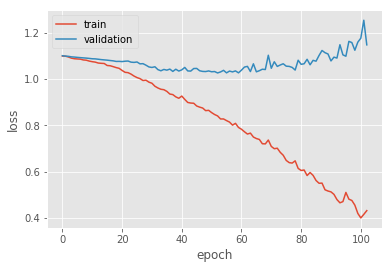

Test loss 1.1398, acc 0.5172
Train loss 0.5285, acc 0.7973


In [22]:
plot_loss(train_data)
model = load_model('3_class_model_200_5_10.h5')
print('Test loss %.4f, acc %.4f' % tuple(model.evaluate(data[1], data[4], verbose=0)))
print('Train loss %.4f, acc %.4f' % tuple(model.evaluate(data[0], data[3], verbose=0)))

##### Hyperparameters



*   Embedding size = 300
*   Window = 3
*   Min count = 10

('Vocabulary size:', 8450)
('Longest review', 1831)
('Unique tokens', 58435)
('padded', (2523, 1831))
('Embedding size', (58436, 301))
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 1831, 301)         17589236  
_________________________________________________________________
bidirectional_7 (Bidirection (None, 512)               1144832   
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 1539      
Total params: 18,735,607
Trainable params: 18,735,607
Non-trainable params: 0
_________________________________________________________________
None
Train on 1766 samples, validate on 378 samples
Epoch 1/2000
1766/1766 [==============================] - 24s 13ms/step - l

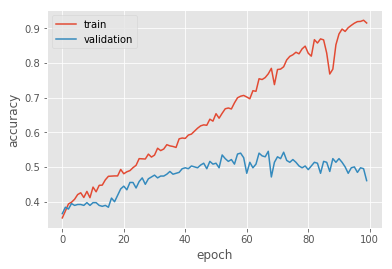

In [23]:
model, data = get_model(3, data3C, data_3_class, 300, 3, 10)
es = EarlyStopping(monitor='val_loss', mode='min', verbose='1', patience=50)
chpt = ModelCheckpoint('3_class_model_300_3_10.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
with tf.device('/gpu:0'):
  train_data = model.fit(data[0], data[3], validation_data=[data[2], data[5]], epochs=2000, batch_size=128, verbose=1, callbacks=[es, chpt])

plot_acc(train_data)

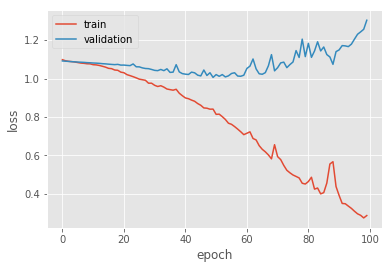

Test loss 1.1296, acc 0.4987
Train loss 0.5891, acc 0.7695


In [24]:
plot_loss(train_data)
model = load_model('3_class_model_300_3_10.h5')
print('Test loss %.4f, acc %.4f' % tuple(model.evaluate(data[1], data[4], verbose=0)))
print('Train loss %.4f, acc %.4f' % tuple(model.evaluate(data[0], data[3], verbose=0)))

##### Hyperparameters



*   Embedding size = 500
*   Window = 3
*   Min count = 10

('Vocabulary size:', 8450)
('Longest review', 1831)
('Unique tokens', 58435)
('padded', (2523, 1831))
('Embedding size', (58436, 501))
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1831, 501)         29276436  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 512)               1554432   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 1539      
Total params: 30,832,407
Trainable params: 30,832,407
Non-trainable params: 0
______

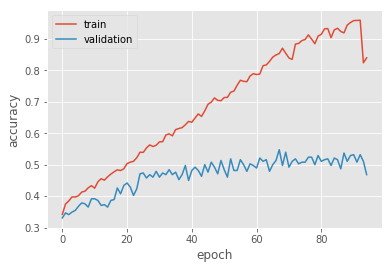

In [13]:
model, data = get_model(3, data3C, data_3_class, 500, 3, 10)
es = EarlyStopping(monitor='val_loss', mode='min', verbose='1', patience=50)
chpt = ModelCheckpoint('3_class_model_500_3_10.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
with tf.device('/gpu:0'):
  train_data = model.fit(data[0], data[3], validation_data=[data[2], data[5]], epochs=2000, batch_size=128, verbose=1, callbacks=[es, chpt])

plot_acc(train_data)

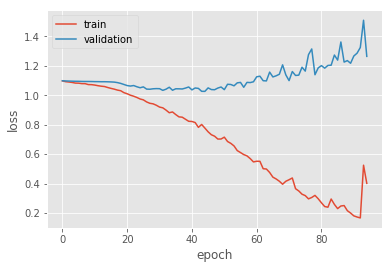

Test loss 1.1357, acc 0.5145
Train loss 0.4046, acc 0.8528


In [14]:
plot_loss(train_data)
model = load_model('3_class_model_500_3_10.h5')
print('Test loss %.4f, acc %.4f' % tuple(model.evaluate(data[1], data[4], verbose=0)))
print('Train loss %.4f, acc %.4f' % tuple(model.evaluate(data[0], data[3], verbose=0)))